# Imports

In [1]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, pandas as pd, sympy as sy, mpmath
from scipy import optimize
from astropy import units as u

In [2]:
mpmath.mp.dps = 30
print(mpmath.mp)

Mpmath settings:
  mp.prec = 103               [default: 53]
  mp.dps = 30                 [default: 15]
  mp.trap_complex = False     [default: False]


# Question 1

Create a Universal Variable Two Body Propogator

In [3]:
def C(z):
    if z>0:
        z = float(z)
        return (1-np.cos(np.sqrt(z)))/z
    elif z==0:
        return 1/2
    elif z<0:
        z_sym = sy.symbols("z_sym")
        f = (sy.cosh(sy.sqrt(-z_sym))-1) / (-z_sym)
        return float(f.subs(z_sym, z).evalf())
    
def S(z):
    if z>0:
        z = float(z)
        return (np.sqrt(z) - np.sin(np.sqrt(z))) / (np.sqrt(z)**3)
    elif z==0:
        return 1/6
    elif z<0:
        z_sym = sy.symbols("z_sym")
        f = (sy.sinh(sy.sqrt(-z_sym)) - sy.sqrt(-z_sym)) / (sy.sqrt(-z_sym)**3)
        f1 = sy.sinh(sy.sqrt(-z_sym))
        return float(f.subs(z_sym, z).evalf())

In [4]:
def kepler(chi: float, mu: float, r_0_mag: float, v_r_0: float, alpha: float, delta_t: float) -> float:
    z = alpha*chi**2
    return (r_0_mag * v_r_0)/np.sqrt(mu) * chi**2 * C(z) + (1-alpha*r_0_mag)*chi**3 * S(z) + r_0_mag * chi - np.sqrt(mu)*delta_t

def kepler_prime(chi: float, mu: float, r_0_mag: float, v_r_0: float, alpha: float) -> float:
    z = alpha*chi**2
    return (r_0_mag * v_r_0)/np.sqrt(mu) * chi * ( 1 - alpha*chi**2 * S(z) ) + (1 - alpha*r_0_mag)*chi**2*C(z) + r_0_mag

def solve_kepler(mu: float, r_0_mag: float, v_r_0: float, alpha: float, delta_t: float, chi_0: float = None, tol = 1e-8, max_iter = 100):

    # if not provided, creating an initial guess for chi
    if not chi_0:
        chi_0 = np.sqrt(mu)*np.abs(alpha)*(delta_t)
    # creating f / fprime
    ratio_i =  kepler(chi_0, mu, r_0_mag, v_r_0, alpha, delta_t) / kepler_prime(chi_0, mu, r_0_mag, v_r_0, alpha)
    
    # starting iterations for newtons method
    chi_i = chi_0
    iter = 0
    while np.abs(ratio_i) > tol and iter <= max_iter:
        chi_i -= ratio_i
        ratio_i =  kepler(chi_i, mu, r_0_mag, v_r_0, alpha, delta_t) / kepler_prime(chi_i, mu, r_0_mag, v_r_0, alpha)
        iter += 1
    
    return chi_i

In [5]:
# deriving state vector for a given delta t
def propogate_orbit(r_0, v_0, delta_t, mu):

    # f and g functions
    def f(chi: float, alpha: float, r_0_mag: float): return 1 - (chi**2 / r_0_mag) * C(alpha*chi**2)

    def g(chi: float, alpha: float, delta_t: float, mu: float): return delta_t - 1/np.sqrt(mu) * chi**3 * S(alpha*chi**2)

    def f_dot(mu: float, r_0_mag: float, r_mag: float, alpha: float, chi: float):
        return np.sqrt(mu)/(r_mag*r_0_mag)*( alpha*chi**3 * S(alpha*chi**2) - chi)

    def g_dot(chi: float, alpha: float, r_mag: float):
        return 1 - chi**2 / r_mag * C(alpha*chi**2)
    
    r_0_mag = np.linalg.norm(r_0)
    v_0_mag = np.linalg.norm(v_0)

    v_r_0 = np.dot(r_0, v_0) / r_0_mag

    alpha = 2/r_0_mag - v_0_mag**2 / mu

    chi = solve_kepler(mu = mu, r_0_mag = r_0_mag, v_r_0 = v_r_0, alpha = alpha, delta_t = delta_t)
    r = f(chi = chi, alpha = alpha, r_0_mag = r_0_mag)*r_0 + g(chi = chi, alpha = alpha, delta_t = delta_t, mu = mu)*v_0
    r_mag = np.linalg.norm(r)

    v = f_dot(mu = mu, r_0_mag = r_0_mag, r_mag = r_mag, alpha = alpha, chi = chi)*r_0 + g_dot(chi = chi, alpha = alpha, r_mag = r_mag)*v_0

    return r, v


# Question 2

In [6]:
def lambert_solver(r_1, r_2, delta_t, mu, z_0 = 0.0, prograde = True, tol = 1e-8, max_iter = 100):
     r_1_mag = np.linalg.norm(r_1)
     r_2_mag = np.linalg.norm(r_2)

     # calculating angle between 
     delta_theta = np.arccos(np.dot(r_1, r_2)/(r_1_mag*r_2_mag))
     r_1_cross_r_2 = np.cross(r_1, r_2)
  
     # determining delta_theta based on orbit direction
     if prograde and (r_1_cross_r_2[-1]) < 0.0:
          delta_theta =  2*np.pi - delta_theta

     if not prograde and (r_1_cross_r_2[-1] >= 0.0):
               delta_theta = 2*np.pi - delta_theta
  
     # Calculating A
     A = np.sin(delta_theta) * np.sqrt( (r_1_mag*r_2_mag)/(1 - np.cos(delta_theta)) )
   
     # Definign y function
     def y(z):
          return r_1_mag + r_2_mag + A*(z*S(z) - 1)/(np.sqrt(C(z)))

     # defining F and F prime
     def F(z): return ( y(z) / C(z) )**(3/2) * (S(z)) + (A*np.sqrt(y(z))) - (np.sqrt(mu)*delta_t)
 
     def F_prime(z):
          if z == 0:
               y_0 = y(0)
               return np.sqrt(2)/40 * y_0**(3/2) + A/8*( np.sqrt(y_0) + A*np.sqrt( 1/(2*y_0) ) )
          else:
               y_z = y(z)
               C_z = C(z)
               S_z = S(z)
               return (y_z/C_z)**(3/2) * ( 1/(2*z)*(C_z - (3*S_z)/(2*C_z))  + (3 * S_z**2)/(4 * C_z) ) + (A/8 * ( 3*S_z/C_z*np.sqrt(y_z) + A*np.sqrt(C_z/y_z) ))

     # starting newton's method to find z
     z_i = z_0
     
     F_over_Fprime = F(z_i)/F_prime(z_i)

     iter = 0
     while np.abs(F_over_Fprime) > tol and iter <= max_iter:
     
          z_i = z_i - F_over_Fprime
          F_over_Fprime = F(z_i)/F_prime(z_i)
          iter += 1

     y_z = y(z_i)
     C_z = C(z_i)
     S_z = S(z_i)

     def f(z): return 1 - y_z/r_1_mag
     def g(z): return A*np.sqrt(y_z/mu)
     def f_dot(z): return np.sqrt(mu)/(r_1_mag*r_2_mag) * np.sqrt(y_z/C_z)*(z_i*S_z - 1)
     def g_dot(z): return 1 - y_z/r_2_mag

     v_1 = 1/g(z_i) * (r_2 - f(z_i)*r_1)
     v_2 = 1/g(z_i) * (g_dot(z_i)*r_2 - r_1)
     
     return v_1, v_2

In [7]:
lambert_solver(
                r_1 = np.array([5644, 2830, 4170]), 
                r_2 = np.array([-2240, 7320, 4980]), 
                delta_t = 1200,
                z_0 = 0.0, 
                mu = 3.986004418e5,
                tol = 1e-8,
                prograde = True,
                max_iter =  4
                )

(array([-4.88638468,  6.0225738 ,  3.04794707]),
 array([-6.91678659,  1.25491188, -1.39876795]))

# Question 3

## Maximum Velocity Values

In [8]:
max_delta_v_rendezvous =  50 # km/s
max_delta_v_flyby = 20 # km/s   

## Generating dates

In [9]:
first_launch_date = pd.Timestamp( year = 2017, month = 1, day = 1, hour = 0, minute = 0, second = 0 ).to_julian_date()
final_launch_date = pd.Timestamp( year = 2017, month = 12, day = 31, hour = 0, minute = 0, second = 0 ).to_julian_date()
launch_window = np.arange(start = first_launch_date, stop = final_launch_date + 1, step = 1)

first_arrival_date = pd.Timestamp( year = 2017, month = 8, day = 1, hour = 0, minute = 0, second = 0 ).to_julian_date()
final_arrival_date = pd.Timestamp( year = 2019, month = 1, day = 31, hour = 0, minute = 0, second = 0 ).to_julian_date()
arrival_window = np.arange(start = first_arrival_date, stop = final_arrival_date + 1, step = 1)

launch_ax, arrival_ax = np.meshgrid(launch_window, arrival_window)

## Given state vectors at JD = 2457754.5

In [10]:
r1I = np.array([3.515868886595499e-2, -3.162046390773074, 4.493983111703389])
r1I = (r1I*u.AU).to(u.km).value
v1I = np.array([-2.317577766980901e-3, 9.843360903693031e-3, -1.541856855538041e-2])
v1I = (v1I*u.AU/u.day).to(u.km/u.s).value

r2I = np.array([7.249472033259724, 14.61063037906177, 14.24274452216359])
r2I = (r2I*u.AU).to(u.km).value
v2I = np.array([-8.241709369476881e-3, -1.156219024581502e-2, -1.317135977481448e-2])
v2I = (v2I*u.AU/u.day).to(u.km/u.s).value


rE = np.array([1.796136509111975e-1, 9.667949206859814e-1, -3.668681017942158e-5])
rE = (rE*u.AU).to(u.km).value
vE = np.array([-1.720038360888334e-2, -3.211186197806460e-3, 7.927736735960840e-7])
vE = (vE*u.AU/u.day).to(u.km/u.s).value

## Earth Trajectory on Launch Window

In [11]:
r_E, v_E = [], []

for delta_t in launch_window-first_launch_date:
    r, v = propogate_orbit(
    rE, vE, delta_t*24*3600, 1.327e11
    )
    r_E.append(r)
    v_E.append(v)

## 1I/’Oumouamoua Trajectory on Arrival Window

In [12]:
r_1I, v_1I = [], []

for delta_t in arrival_window-first_launch_date:
    r, v = propogate_orbit(
    r1I, v1I, delta_t*24*3600, 1.327e11
    )
    r_1I.append(r)
    v_1I.append(v)

## Creating Porkchop Plots

In [15]:
delta_v_data_I1_flyby = np.empty((len(launch_window), len(arrival_window)))
delta_v_data_I1_rv = np.empty((len(launch_window), len(arrival_window)))

In [18]:
error_count = 0
for i in range(len(launch_window)):
    print(i)
    earth_pos = r_E[i]
    earth_vel = v_E[i]
    for j in range(len(arrival_window)):
        I_pos = r_1I[j]
        I_vel = v_1I[j]

        delta_v = None
        if arrival_window[j] <= launch_window[i]:
            delta_v_data_I1_flyby[j][i] = delta_v
            delta_v_data_I1_rv[j][i] = delta_v
            continue
        else:
            delta_t = arrival_window[j] - launch_window[i]
            try:
                v_E_prograde, v_I_prograde = lambert_solver(earth_pos, I_pos, delta_t*24*3600, 1.327e11, prograde = True)
                v_E_retrograde, v_I_retrograde = lambert_solver(earth_pos, I_pos, delta_t*24*3600, 1.327e11, prograde = False)
            except: 
                error_count += 1
                print(f"Error Counter: {error_count}")
            delta_v_prograde = np.linalg.norm(v_E_prograde - earth_vel) + np.linalg.norm(v_I_prograde - I_vel)
            delta_v_retrograde = np.linalg.norm(v_E_retrograde - earth_vel) + np.linalg.norm(v_I_retrograde - I_vel)
            
            if abs(delta_v_prograde) < abs(delta_v_retrograde):
                delta_v = delta_v_prograde
            else:
                delta_v = delta_v_retrograde
            if delta_v < max_delta_v_flyby:
                delta_v_data_I1_flyby[j][i] = delta_v
            else: 
                delta_v_data_I1_flyby[j][i] = None
                
            if delta_v < max_delta_v_rendezvous:
                delta_v_data_I1_rv[j][i] = delta_v
            else: 
                delta_v_data_I1_rv[j][i] = None

0
Error Counter: 1


C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/1396648881.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return r_1_mag + r_2_mag + A*(z*S(z) - 1)/(np.sqrt(C(z)))
C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/1396648881.py:24: RuntimeWarning: invalid value encountered in double_scalars
  def F(z): return ( y(z) / C(z) )**(3/2) * (S(z)) + (A*np.sqrt(y(z))) - (np.sqrt(mu)*delta_t)
C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/1396648881.py:24: RuntimeWarning: invalid value encountered in sqrt
  def F(z): return ( y(z) / C(z) )**(3/2) * (S(z)) + (A*np.sqrt(y(z))) - (np.sqrt(mu)*delta_t)
C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/1396648881.py:34: RuntimeWarning: invalid value encountered in double_scalars
  return (y_z/C_z)**(3/2) * ( 1/(2*z)*(C_z - (3*S_z)/(2*C_z))  + (3 * S_z**2)/(4 * C_z) ) + (A/8 * ( 3*S_z/C_z*np.sqrt(y_z) + A*np.sqrt(C_z/y_z) ))
C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/1396648881.py:34: RuntimeWarning: invalid value encount

Error Counter: 2
Error Counter: 3


C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/1396648881.py:21: RuntimeWarning: overflow encountered in double_scalars
  return r_1_mag + r_2_mag + A*(z*S(z) - 1)/(np.sqrt(C(z)))
C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/1396648881.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  F_over_Fprime = F(z_i)/F_prime(z_i)
C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/3799470352.py:15: RuntimeWarning: invalid value encountered in sin
  return (np.sqrt(z) - np.sin(np.sqrt(z))) / (np.sqrt(z)**3)
C:\Users\djd14\AppData\Local\Temp/ipykernel_4480/3799470352.py:4: RuntimeWarning: invalid value encountered in cos
  return (1-np.cos(np.sqrt(z)))/z


1
Error Counter: 4
2
Error Counter: 5
3
4
Error Counter: 6
Error Counter: 7
Error Counter: 8
5
6
Error Counter: 9
7
Error Counter: 10
Error Counter: 11
8
Error Counter: 12
9
Error Counter: 13
Error Counter: 14
10
Error Counter: 15
Error Counter: 16
Error Counter: 17
11
Error Counter: 18
12
Error Counter: 19
13
Error Counter: 20
14
15
Error Counter: 21
Error Counter: 22
16
17
18
Error Counter: 23
Error Counter: 24
19
20
21
Error Counter: 25
Error Counter: 26
Error Counter: 27
22
Error Counter: 28
Error Counter: 29
Error Counter: 30
Error Counter: 31
23
Error Counter: 32
24
Error Counter: 33
Error Counter: 34
Error Counter: 35
Error Counter: 36
25
Error Counter: 37
Error Counter: 38
26
Error Counter: 39
27
Error Counter: 40
Error Counter: 41
28
Error Counter: 42
Error Counter: 43
29
Error Counter: 44
Error Counter: 45
30
Error Counter: 46
Error Counter: 47
Error Counter: 48
31
Error Counter: 49
32
33
34
Error Counter: 50
35
36
Error Counter: 51
Error Counter: 52
37
38
Error Counter: 53
3

In [21]:
df = pd.DataFrame(delta_v_data_I1_rv, columns = pd.to_datetime(arrival_window, unit = "D", origin = "julian"), index = pd.to_datetime(launch_window, unit = "D", origin = "julian"))

In [22]:
len(launch_window), np.shape(delta_v_data_I1_rv)

(365, (365, 549))

TypeError: FigureBase.colorbar() missing 1 required positional argument: 'mappable'

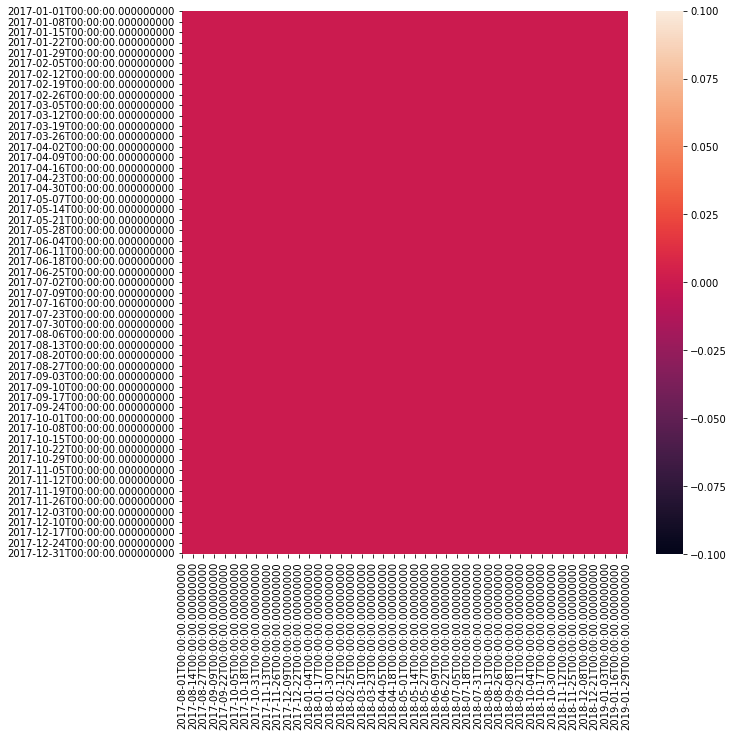

In [31]:
fig = plt.figure(figsize = (10, 10))
ax = sns.heatmap(df)
fig.colorbar(label = "Delta V")

ValueError: x and y must be the same size

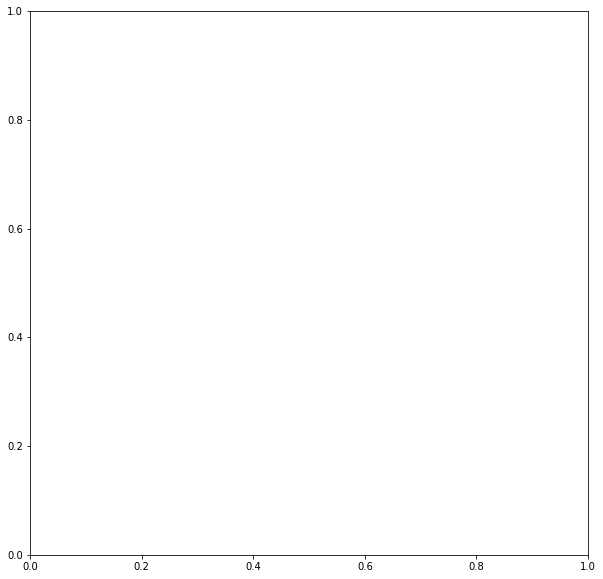

In [27]:
plt.figure(figsize = (10, 10))

plt.scatter(launch_window, arrival_window, c = delta_v_data_I1_flyby)
plt.colorbar(label = f"$\Delta$V")
plt.xlabel("Launch Date"), plt.ylabel("Arrival Date"), plt.title("Oumouamoua Rendezvous")

# Question 4

## Maximum Velocity Values

## Comet 2I/Borisov Trajectory on Arrival Window

In [13]:
r_2I, v_2I = [], []

for delta_t in arrival_window-first_launch_date:
    r, v = propogate_orbit(
    r2I, v2I, delta_t*24*3600, 1.327e11
    )
    r_2I.append(r)
    v_2I.append(v)

# Question 5

Initial State Vectors to Orbital Elements

In [46]:
def state2elem(r, v, mu):
    mu_E = 398600
    def h(r, v): return np.cross(r,v)

    def a(r, v, mu = mu_E):
        return (2/np.linalg.norm(r) - np.linalg.norm(v)**2/mu)**-1

    def e(r, v, mu = mu_E):
        return 1/mu*np.cross(v, h(r, v)) - r/np.linalg.norm(r)

    def inclination(r, v):
        h_vec = h(r, v)
        return np.arccos( np.dot(h_vec, np.array([0, 0, 1]))/np.linalg.norm(h_vec) )

    def nodes(r, v):
        return np.cross( np.array([0, 0, 1]), h(r, v) )

    def raan(r, v):
        n = nodes(r, v)
        return np.arccos( np.dot( n, np.array([1, 0, 0]) ) / np.linalg.norm(n) )

    def argument_of_periapsis(r, v, mu = mu_E):
        n = nodes(r, v)
        return np.arccos( np.dot(n, e(r, v)) / ( np.linalg.norm(n)*np.linalg.norm(e(r, v)) ) )

    def f(r, v, mu = mu_E): 
        h_mag = np.linalg.norm(h(r, v))
        e_mag = np.linalg.norm(e(r, v, mu))
        r_mag = np.linalg.norm(r)
        nu = np.arccos( 1/e_mag * (h_mag**2 / (mu*r_mag) - 1) )
        
        if np.dot(r, v) < 0:
            nu = 2*np.pi - nu
        return nu
    
    return a(r, v, mu), np.linalg.norm(e(r, v, mu)), inclination(r, v), raan(r, v), argument_of_periapsis(r, v, mu), f(r, v)

# Question 6

How realistic are the mission scenarios